In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils
import glob
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [2]:
class PostureDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        files = glob.glob(root + '*.csv')
        self.data = list([pd.read_csv(f) for f in files])

    def __getitem__(self, idx):
        window = self.data[idx]['window'][0]
        label = self.data[idx][['supine', 'prone', 'side', 'sitting', 'unknown']].values[0]
        
        data = []
        data.append(self.data[idx]['sens_x'].values)
        data.append(self.data[idx]['sens_y'].values)
        data.append(self.data[idx]['sens_z'].values)

        data = torch.tensor(np.array(data), dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        #Perform min-max normalization
        # data = (data - data.min()) / (data.max() - data.min())

        return idx, data, label, window

    def __len__(self):
        return len(self.data)

In [3]:
dataset = PostureDataset('data/processed/')

In [4]:
_, data, label, _ = dataset[1000]

In [5]:
# Define train, valid, test split (80%, 10%, 10%)
train_size = int(0.75 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

In [6]:
len(dataset), len(train_dataset), len(valid_dataset), len(test_dataset)

(5301, 3975, 530, 796)

In [7]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

In [8]:
input_channels = 3
channel_sequence_dim = 200
hidden_dim = 100
output_class = 5

In [9]:
class GRU_Linear_Network(nn.Module):
    def __init__(self, input_sequence_length, hidden_dimension) -> None:
        super(GRU_Linear_Network, self).__init__()

        self.gru = nn.GRU(input_sequence_length, hidden_dimension, batch_first=True)
        self.linear = nn.Linear(hidden_dimension, 40)
        self.dropout = nn.Dropout(0.65)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)

        if self.training:
            x = self.dropout(x)
        
        x = F.relu(x)      # Change the activation here
        return x

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, channels, input_sequence_length, hidden_dimension, output_dimension) -> None:
        super(NeuralNetwork, self).__init__()
        
        self.channels = channels
        self.output_dimension = output_dimension
        
        self.level1_sensx = GRU_Linear_Network(input_sequence_length, hidden_dimension)
        self.level1_sensy = GRU_Linear_Network(input_sequence_length, hidden_dimension)
        self.level1_sensz = GRU_Linear_Network(input_sequence_length, hidden_dimension)

        self.level2_linear = nn.Linear(channels*40, output_dimension)

    def forward(self, x):
        
        # Level 1
        level1_outputs_sensx     = self.level1_sensx(x[:, 0, :])
        level1_outputs_sensy     = self.level1_sensy(x[:, 1, :])
        level1_outputs_sensz     = self.level1_sensz(x[:, 2, :])

        # Level 2
        linear_inputs = torch.cat((level1_outputs_sensx, level1_outputs_sensy, level1_outputs_sensz), dim=1)
        linear_outputs = self.level2_linear(linear_inputs)

        linear_outputs = F.relu(linear_outputs)

        return linear_outputs

In [11]:
model = NeuralNetwork(input_channels, channel_sequence_dim, hidden_dim, output_class)

In [12]:
print(model)

NeuralNetwork(
  (level1_sensx): GRU_Linear_Network(
    (gru): GRU(200, 100, batch_first=True)
    (linear): Linear(in_features=100, out_features=40, bias=True)
    (dropout): Dropout(p=0.65, inplace=False)
  )
  (level1_sensy): GRU_Linear_Network(
    (gru): GRU(200, 100, batch_first=True)
    (linear): Linear(in_features=100, out_features=40, bias=True)
    (dropout): Dropout(p=0.65, inplace=False)
  )
  (level1_sensz): GRU_Linear_Network(
    (gru): GRU(200, 100, batch_first=True)
    (linear): Linear(in_features=100, out_features=40, bias=True)
    (dropout): Dropout(p=0.65, inplace=False)
  )
  (level2_linear): Linear(in_features=120, out_features=5, bias=True)
)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
def one_hot_ce_loss(outputs, targets):
    criterion = nn.CrossEntropyLoss()
    _, labels = torch.max(targets, dim=1)
    return criterion(outputs, labels)

In [15]:
def train(optimizer, criterion):
    epoch_loss = 0
    model.train()
    for idx, data, label, window in train_loader:
        datas = data.to(device=device)
        labels = label.to(device=device)
        
        # Forward pass
        outputs = model(datas)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

def validate(criterion):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []

        for idx, data, label, window in valid_loader:
            data = data.to(device=device)
            labels = label.to(device=device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
    
    return epoch_loss / len(valid_loader)


def test():
    print("Testing the Model...")
    
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []

        for idx, data, label, window in test_loader:
            data = data.to(device=device)
            label = label.to(device=device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(label.data, 1)

            y_true.append(label)
            y_pred.append(predicted)
            
        concat_y_true = torch.cat(y_true, dim=0)
        concat_y_pred = torch.cat(y_pred, dim=0)

        print(classification_report(concat_y_true.cpu(), concat_y_pred.cpu()))

In [16]:
# Define loss function and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Train the model
epochs = 50
model.to(device=device)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    train_loss = train(optimizer, one_hot_ce_loss)
    train_losses.append(train_loss)
    
    valid_loss = validate(one_hot_ce_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

test()

Epoch: 1/50, Train Loss: 1.5535, Valid Loss: 1.4478
Epoch: 2/50, Train Loss: 1.4485, Valid Loss: 1.3375
Epoch: 3/50, Train Loss: 1.3251, Valid Loss: 1.1890
Epoch: 4/50, Train Loss: 1.2090, Valid Loss: 1.1604
Epoch: 5/50, Train Loss: 1.1818, Valid Loss: 1.1302
Epoch: 6/50, Train Loss: 1.1540, Valid Loss: 1.1310
Epoch: 7/50, Train Loss: 1.1488, Valid Loss: 1.1439
Epoch: 8/50, Train Loss: 1.1461, Valid Loss: 1.1308
Epoch: 9/50, Train Loss: 1.1271, Valid Loss: 1.1262
Epoch: 10/50, Train Loss: 1.1379, Valid Loss: 1.1236
Epoch: 11/50, Train Loss: 1.1220, Valid Loss: 1.1170
Epoch: 12/50, Train Loss: 1.1168, Valid Loss: 1.1082
Epoch: 13/50, Train Loss: 1.1142, Valid Loss: 1.1102
Epoch: 14/50, Train Loss: 1.1106, Valid Loss: 1.1134
Epoch: 15/50, Train Loss: 1.1149, Valid Loss: 1.1334
Epoch: 16/50, Train Loss: 1.1115, Valid Loss: 1.1164
Epoch: 17/50, Train Loss: 1.1118, Valid Loss: 1.1304
Epoch: 18/50, Train Loss: 1.1033, Valid Loss: 1.1138
Epoch: 19/50, Train Loss: 1.1024, Valid Loss: 1.1142
Ep

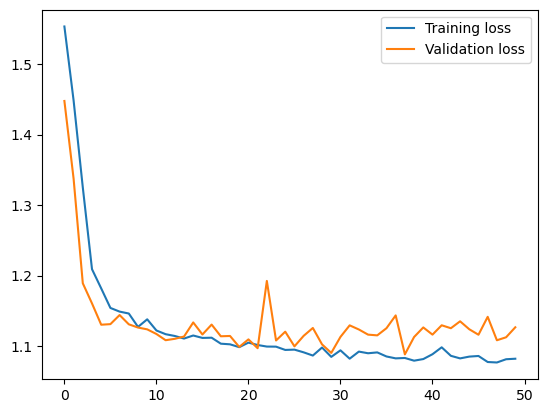

In [17]:
#plotting the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.savefig('losses - relu activated.png')
plt.show()

In [ ]:
# save model
torch.save(model.state_dict(), 'model-relu.pth')